# Load Data

Only Consider Player with:
- at least 8 games played
- at least 60 minutes played

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import utils


MIN_GAMES_PLAYED = 8
MIN_MINUTES_PLAYED = 60


df_team_info_squad, df_team_info_opponent, df_squad_features, df_opponent_features = utils.load_team_statistics()
df_features, df_player_info = utils.load_player_statistics()

mask = (df_player_info["Matches Played"] > MIN_GAMES_PLAYED) & (df_player_info["Playing Time_Min"] > MIN_MINUTES_PLAYED) & (df_player_info["Pos"] != "GK")
player_info = df_player_info[mask]
df_features = df_features[mask]

adv_goalkeeping = ['Goals_GA', 'Goals_PKA', 'Goals_FK', 'Goals_CK', 'Goals_OG', 'PSxG',
       'PSxG/SoT', 'PSxG+/-', '/90', 'Launched_Cmp', 'Launched_Att',
       'Launched_Cmp%', 'Passes_Att', 'Passes_Thr', 'Passes_Launch%',
       'Passes_AvgLen', 'Goal Kicks_Att', 'Goal Kicks_Launch%',
       'Goal Kicks_AvgLen', 'Opp', 'Stp', 'Stp%', '#OPA', '#OPA/90',
       'AvgDist']
goalkeeping_cols = ['GA',
       'GA90', 'SoTA', 'Saves', 'Save%', 'W', 'D', 'L', 'CS', 'CS%',
       'Penalty Kicks_PKatt', 'Penalty Kicks_PKA', 'Penalty Kicks_PKsv',
       'Penalty Kicks_PKm', 'Penalty Kicks_Save%']
playing_time_cols = ['Playing Time_Minutes', 'Playing Time_Mn/MP','Starts', 'Mn/Start', 'Compl',
                     'Subs', 'unSub', 'PPM','onG', 'onGA','On-Off'
                    ]
col_to_drop = adv_goalkeeping + goalkeeping_cols + playing_time_cols

df_features = df_features.drop(columns = col_to_drop)
df_squad_features = df_squad_features.drop(columns=col_to_drop)
df_opponent_features = df_opponent_features.drop(columns=col_to_drop)

player_info.shape, df_features.shape, df_squad_features.shape, df_opponent_features.shape


((2766, 13), (2766, 86), (134, 86), (134, 86))

# Helper functions

In [2]:
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.cluster import KMeans

def plot_cluster_intertia(X, n_cluster=12):
    intertia = []
    for i in range(1,n_cluster):
        model = KMeans(n_clusters = i,init = "k-means++", max_iter = 300, n_init = 10, random_state = 42)
        model.fit(X)
        intertia.append(model.inertia_)


    plt.figure(figsize = (6,6))
    plt.plot(range(1,n_cluster), intertia, linewidth=2, markersize=6,marker='o',color = 'purple')
    plt.xticks(range(1,n_cluster))
    plt.xlabel("Number of clusters")
    plt.ylabel("Intertia")
    plt.show()

def create_3d_plot(data, labels, player_names):
    fig_3d = px.scatter_3d(
    data, x=0, y=1, z=2,
    color=labels,
    hover_name=player_names
    )
    fig_3d.update_traces(marker_size=2.5)
    fig_3d.show()

# Goal: Find a Team that matches with David Raum

__Player Profile__
- known for creating lots of chances by running along side and crosses into the penalty area, leading to many goals
- he is also a wing defender with fast pace

__Team Profile__
The team has to have the same kind of playing style meaning find a team that matches with the following data:
- Crosses, Crosses Into Penalty Area
- Comes along with clear Stricker that has many header attempts

__Challenge__:
- no heatmap
- no speed data

In [3]:
# Club with most crosses
df_squad_features["Crs"].sort_values(ascending=False) 

Team
Valencia         925.0
Athletic Club    918.0
Inter            885.0
Fiorentina       880.0
Sporting CP      843.0
                 ...  
Leverkusen       461.0
M'Gladbach       441.0
Lorient          434.0
Arouca           427.0
Paris S-G        399.0
Name: Crs, Length: 134, dtype: float64

In [4]:
print(f"Player avg: {df_features['Crs'].sort_values(ascending=False).mean()}")
print(f"Player median: {df_features['Crs'].sort_values(ascending=False).median()}")
print(f"David Raum: {df_features['Crs'].loc['David Raum']}")

Player avg: 30.443239334779467
Player median: 14.0
David Raum: 141.0


## No differentiation & Cosine

Without Scaling

In [5]:
from sklearn.metrics.pairwise import cosine_similarity

raum_features = df_features.loc["David Raum"].values.reshape(1, -1)  # Reshape to 2D (1, n_features)
similarities = cosine_similarity(raum_features, df_squad_features.values)

eval = pd.DataFrame({
    "Team": df_squad_features.index,
    "Sim": similarities.reshape(-1)
})

eval.sort_values("Sim",ascending=False)

,Team,Sim
116,Benfica,0.999161
4,Liverpool,0.998971
118,Braga,0.998851
80,Inter,0.998794
22,RB Leipzig,0.998689
...,...,...
59,Lens,0.988341
69,Montpellier,0.988337
68,Reims,0.988163
76,Troyes,0.987126


Test different Scaler: Team and Raum

In [6]:
from sklearn.preprocessing import StandardScaler, Normalizer,MinMaxScaler ,MaxAbsScaler,RobustScaler
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

scalers = [StandardScaler(), Normalizer(),MinMaxScaler() ,MaxAbsScaler(),RobustScaler()]

for scaler in scalers:
    df_features_scaled = pd.DataFrame(scaler.fit_transform(df_features), index=df_features.index, columns=df_features.columns)
    df_squad_features_scaled = pd.DataFrame(scaler.fit_transform(df_squad_features), index=df_squad_features.index, columns=df_squad_features.columns)

    raum_features_scaled = df_features_scaled.loc["David Raum"].values.reshape(1, -1)
    similarities = cosine_similarity(raum_features_scaled, df_squad_features_scaled.values)

    eval = pd.DataFrame({
        "Team": df_squad_features_scaled.index,  # Club names
        "Sim": similarities.reshape(-1)  # Similarity scores reshaped to 1D array
    })

    eval.sort_values("Sim", ascending=False, inplace=True)
    print(scaler)
    print(eval)

StandardScaler()
             Team       Sim
85     Fiorentina  0.414555
45  Athletic Club  0.352797
73         Nantes  0.338575
80          Inter  0.324241
53       Valencia  0.292390
..            ...       ...
32  Werder Bremen -0.318783
25     Leverkusen -0.320318
34       Augsburg -0.323357
31     Hoffenheim -0.362240
37     Hertha BSC -0.371977

[134 rows x 2 columns]
Normalizer()
            Team       Sim
116      Benfica  0.999161
4      Liverpool  0.998971
118        Braga  0.998851
80         Inter  0.998794
22    RB Leipzig  0.998689
..           ...       ...
59          Lens  0.988341
69   Montpellier  0.988337
68         Reims  0.988163
76        Troyes  0.987126
67       Lorient  0.983617

[134 rows x 2 columns]
MinMaxScaler()
                Team       Sim
128   Gil Vicente FC  0.813246
11           Chelsea  0.810718
50        Celta Vigo  0.810475
66              Nice  0.801344
86           Bologna  0.799476
..               ...       ...
15   Nott'ham Forest  0.546973

__Thoughts__:
- StandardScaler() and MinMaxScaler() create a wider range 
- Normalizer() results to high sim for all + its creates sim results as without, because cosine normalizes as well

Test different Scaler: Raum vs other players 

In [7]:
from sklearn.preprocessing import StandardScaler, Normalizer,MinMaxScaler ,MaxAbsScaler,RobustScaler


scalers = [StandardScaler(), Normalizer(),MinMaxScaler() ,MaxAbsScaler(),RobustScaler()]

for scaler in scalers:
    df_scaled_features = pd.DataFrame(scaler.fit_transform(df_features), index=df_features.index, columns=df_features.columns)

    raum_features_scaled = df_scaled_features.loc["Christopher Nkunku"].values.reshape(1, -1)
    similarities = cosine_similarity(raum_features_scaled, df_scaled_features.drop(index="Christopher Nkunku").values)

    eval = pd.DataFrame({
        "Player": df_scaled_features.drop(index="Christopher Nkunku").index,
        "Sim": similarities.reshape(-1)
    })

    eval.sort_values("Sim", ascending=False, inplace=True)
    print(scaler)
    print(eval)


StandardScaler()
                   Player       Sim
2388           Rafa Silva  0.868788
531     Randal Kolo Muani  0.846155
1689      Ademola Lookman  0.838834
1629        Ciro Immobile  0.829907
1398      Folarin Balogun  0.829610
...                   ...       ...
2310     Peer Koopmeiners -0.610193
699   Ohis Felix Uduokhai -0.621462
2334       Julius Dirksen -0.641705
307          Remo Freuler -0.644037
538       Kristijan Jakić -0.655626

[2765 rows x 2 columns]
Normalizer()
                 Player       Sim
790       Ferrán Torres  0.999340
2181       Rami Al Hajj  0.999273
503       Roland Sallai  0.999258
724         Enzo Millot  0.999248
191        Harry Wilson  0.999238
...                 ...       ...
2258     Anthony Musaba  0.840016
1475       Alberth Elis  0.815114
1272     Matthis Abline  0.722226
1920  Gabriel Strefezza  0.008497
1089     Hugo Guillamón  0.007044

[2765 rows x 2 columns]
MinMaxScaler()
                  Player       Sim
2388          Rafa Silva  0.95

In [8]:
print(eval[eval["Player"] == "Manuel Neuer"])
print(eval[eval["Player"] == "Dani Olmo"])
print(eval[eval["Player"] == "Konrad Laimer"])

Empty DataFrame
Columns: [Player, Sim]
Index: []
        Player       Sim
467  Dani Olmo  0.717783
            Player       Sim
462  Konrad Laimer  0.250947


__Thoughts__:
<br>
- Use __StandardScaler, RobustScaler, MinMaxScaler__
- Here I get negative sim. compared to my cosine sim function
- The goalkeeper are not the least similar all the time which is weird 

Testing my cosine method

In [9]:
import utils

scalers = [StandardScaler(), Normalizer(),MinMaxScaler() ,MaxAbsScaler(),RobustScaler()]

for scaler in scalers:
    df_scaled_features = pd.DataFrame(scaler.fit_transform(df_features), index=df_features.index, columns=df_features.columns)

    q_player_idx = df_scaled_features.index.get_loc("Christopher Nkunku")
    eval= utils.get_top_k_similar_players(df_scaled_features, q_player_idx, player_info,top_k=2940)
    print(scaler)
    print(eval[["Player","cosine_similarity", "Global Pos"]])


StandardScaler()
                                  Player  cosine_similarity Global Pos
Player                                                                
Christopher Nkunku    Christopher Nkunku           1.000000         FW
Rafa Silva                    Rafa Silva           0.868788         MF
Randal Kolo Muani      Randal Kolo Muani           0.846155         FW
Ademola Lookman          Ademola Lookman           0.838834         FW
Ciro Immobile              Ciro Immobile           0.829907         FW
...                                  ...                ...        ...
Peer Koopmeiners        Peer Koopmeiners          -0.610193         MF
Ohis Felix Uduokhai  Ohis Felix Uduokhai          -0.621462         DF
Julius Dirksen            Julius Dirksen          -0.641705         DF
Remo Freuler                Remo Freuler          -0.644037         MF
Kristijan Jakić          Kristijan Jakić          -0.655626         DF

[2766 rows x 3 columns]
Normalizer()
                      

My Cosine function has not the exact same numbers. There are notable differences but its the same picture 

__Try__ Dimensionality Reduction and then Cosine

In [10]:
from sklearn.preprocessing import StandardScaler, Normalizer,MinMaxScaler ,MaxAbsScaler,RobustScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.pipeline import make_pipeline

scalers = [StandardScaler(), Normalizer(),MinMaxScaler() ,MaxAbsScaler(),RobustScaler()]
q_player_idx = player_info.index.get_loc("David Raum")

for scaler in scalers:
    pca = PCA(n_components=30)
    pipe = make_pipeline(scaler, pca)

    components_player = pipe.fit_transform(df_features)
    components_query_player = components_player[q_player_idx]

    components_squad = pipe.fit_transform(df_squad_features)

    
    similarities = cosine_similarity(components_query_player.reshape(1, -1), components_squad)

    eval = pd.DataFrame({
        "Team": df_team_info_squad.index,  # Club names
        "Sim": similarities.reshape(-1)  # Similarity scores reshaped to 1D array
    })

    eval = eval.sort_values("Sim",ascending=False)

    print(scaler)
    print(eval)
    

StandardScaler()
              Team       Sim
4        Liverpool  0.609420
45   Athletic Club  0.588279
85      Fiorentina  0.557083
80           Inter  0.548145
60       Marseille  0.473144
..             ...       ...
112      Excelsior -0.486626
32   Werder Bremen -0.494589
46        Mallorca -0.522991
124       Boavista -0.551460
120         Arouca -0.566483

[134 rows x 2 columns]
Normalizer()
              Team       Sim
130   Portimonense  0.977477
104        Utrecht  0.972453
32   Werder Bremen  0.971782
27       Wolfsburg  0.968421
123      Famalicão  0.966504
..             ...       ...
64            Lyon -0.972498
77          Angers -0.976212
66            Nice -0.976400
62           Lille -0.977123
59            Lens -0.982187

[134 rows x 2 columns]
MinMaxScaler()
              Team       Sim
49         Sevilla  0.608116
80           Inter  0.567837
45   Athletic Club  0.555607
85      Fiorentina  0.542937
4        Liverpool  0.529721
..             ...       ...
14     B

__Conclusion__:
Best and worst have equal number of crosses and crosses into penalty area.

- be more fine-grained with features

## Cluster and predict Raum to team

__Cluster__:
Now in this step, I want to investigate use clustering in order to categorize in different playing styles and their behaviour. We look at:
<br>
- defending
- possession
- passing
- goal and shot creation
- shooting

#### Inspect Defending

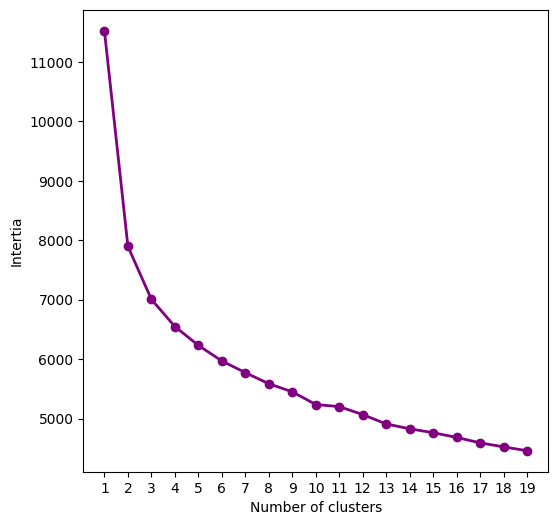

In [11]:
def_cols = ['Tackles_Def 3rd', 'Tackles_Mid 3rd','Tackles_Att 3rd']

df_squad_features_scaled = StandardScaler().fit_transform(df_squad_features)

plot_cluster_intertia(df_squad_features_scaled, n_cluster=20)

<Axes: ylabel='count'>

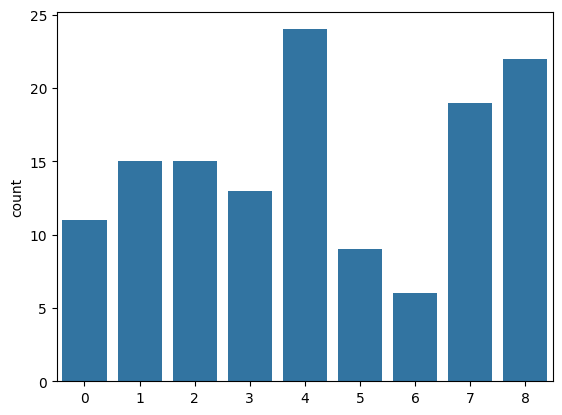

In [12]:
model = KMeans(n_clusters = 9, init = "k-means++", max_iter = 300, n_init = 12, random_state = 42)
labels = model.fit_predict(df_squad_features_scaled)

sns.countplot(x=np.array(labels))

In [13]:
eval = pd.DataFrame({
    'Labels': labels,
    "Team" : df_team_info_squad["Team"],
    "Tackles_Def 3rd": df_squad_features["Tackles_Def 3rd"],
    "Tackles_Mid 3rd": df_squad_features["Tackles_Mid 3rd"],
    "Tackles_Att 3rd": df_squad_features["Tackles_Att 3rd"]
})
eval.sort_values("Tackles_Att 3rd",ascending=False).head(20)

,Labels,Team,Tackles_Def 3rd,Tackles_Mid 3rd,Tackles_Att 3rd
Team,,,,,
Lyon,3,Lyon,306.0,282.0,135.0
Leeds United,8,Leeds United,376.0,343.0,121.0
Arsenal,6,Arsenal,238.0,212.0,118.0
Benfica,3,Benfica,243.0,305.0,112.0
Liverpool,3,Liverpool,228.0,250.0,112.0
Chelsea,5,Chelsea,363.0,267.0,110.0
Marseille,3,Marseille,271.0,304.0,110.0
Nice,3,Nice,415.0,295.0,108.0
Porto,2,Porto,251.0,234.0,108.0


In [14]:
fig_3d = px.scatter_3d(
    eval, 
    x='Tackles_Def 3rd', 
    y='Tackles_Mid 3rd', 
    z='Tackles_Att 3rd',
    color=eval["Labels"],           # Color by cluster or label
    hover_name=eval["Team"],        # Hover over teams
    title="3D Scatter of Tackles Across Thirds of the Field"
)
fig_3d.update_traces(marker_size=4)
fig_3d.show()

### Predict Raum to cluster

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from umap import UMAP
import plotly.express as px
import plotly.graph_objects as go

raum_idx = player_info.index.get_loc("David Raum")

mask_def = player_info["Global Pos"] == "DF"

pipe = make_pipeline(StandardScaler(), UMAP(n_components=2, random_state=42))
df_player_features_scaled = pipe.fit_transform(df_features)
df_team_features_scaled = pipe.fit_transform(df_squad_features)

c:\Users\Alexander Lorenz\anaconda3\envs\ml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

c:\Users\Alexander Lorenz\anaconda3\envs\ml\Lib\site-packages\umap\umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [16]:
fig = px.scatter(
    x=df_player_features_scaled[:,0], 
    y=df_player_features_scaled[:,1],
    color=player_info["Global Pos"],            
    hover_name=player_info["Player"],         
    title="Scatter Plot"
)
fig.update_traces(marker_size=4)

fig.add_trace(
    go.Scatter(
        x=[df_player_features_scaled[raum_idx, 0]],  # x coordinate for David Raum
        y=[df_player_features_scaled[raum_idx, 1]],  # y coordinate for David Raum
        mode='markers',
        marker=dict(color='black', size=12, symbol='star'),  # Highlight with a star symbol
        name="David Raum",  # Label for the legend
        hovertext="David Raum"  # Custom hover text for David Raum
    )
)


fig.show()

### plot_player_comparison

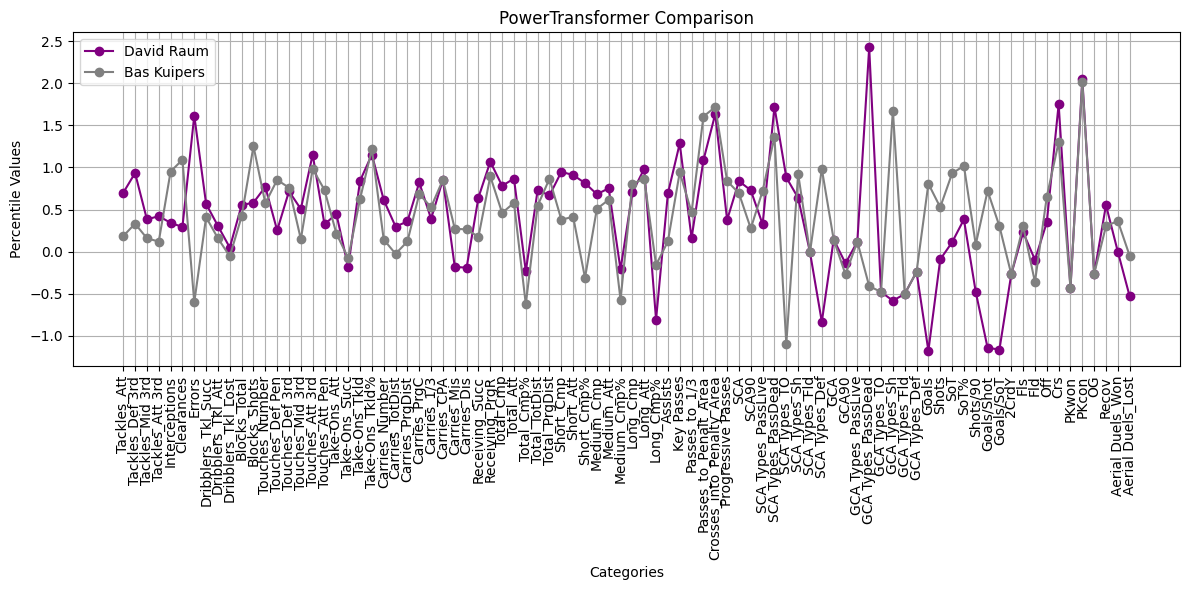

In [31]:
from sklearn.preprocessing import QuantileTransformer,PowerTransformer

def plot_player_comparison(query_player_name, similar_player_name, features, player_info,Transformer=QuantileTransformer):
    X_quantiles = Transformer().fit_transform(features)

    query_player = X_quantiles[player_info.index.get_loc(query_player_name),]
    similar_player = X_quantiles[player_info.index.get_loc(similar_player_name),]

    plt.figure(figsize=(12, 6))
    plt.plot(features.columns, query_player, marker='o', color='purple', label=query_player_name)
    plt.plot(features.columns, similar_player, marker='o', color='grey', label=similar_player_name)
    plt.title(f'{Transformer.__name__} Comparison')
    plt.xlabel('Categories')  # Change this to an appropriate label if needed
    plt.ylabel('Percentile Values')
    plt.xticks(rotation=90)
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_player_comparison("David Raum", "Bas Kuipers", df_features, player_info,PowerTransformer)

### plot_top_k_closest_features

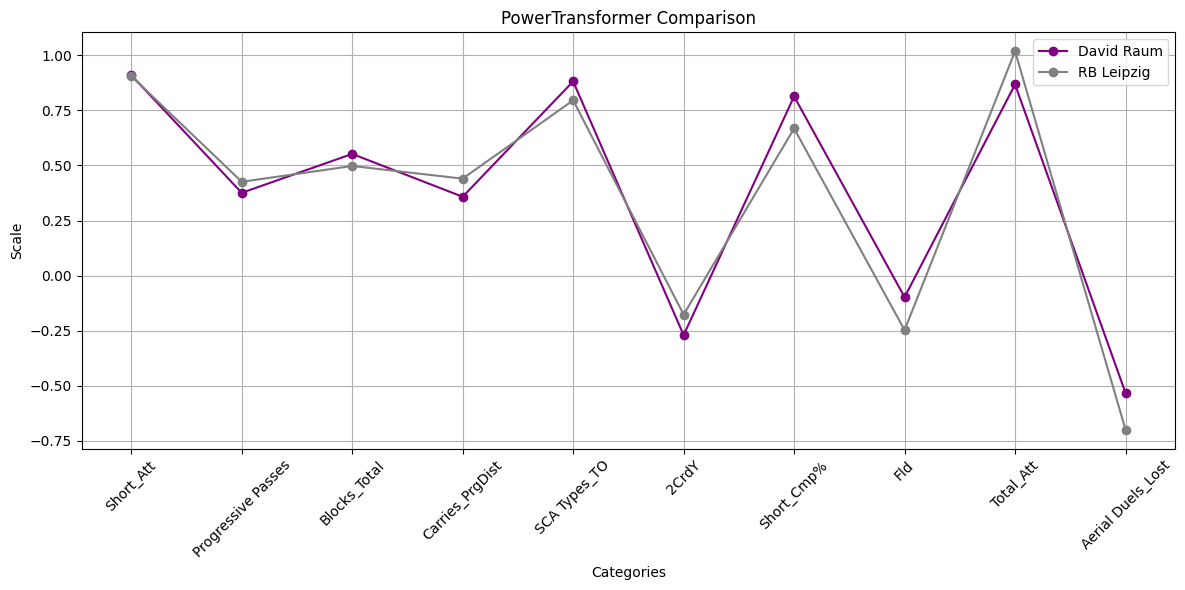

In [30]:
from sklearn.preprocessing import QuantileTransformer,PowerTransformer
def plot_top_k_closest_features(query_player, target, features_players,feautures_team, player_info, squad_info, Transformer=QuantileTransformer):
    X_player= Transformer().fit_transform(features_players)
    X_team = Transformer().fit_transform(feautures_team)

    query = X_player[player_info.index.get_loc(query_player), :]
    team = X_team[squad_info.index.get_loc(target), :]

    distance_matrix = np.abs(query - team)
    closest_feature_indices = np.argsort(distance_matrix)[:10]
    df_features.columns[closest_feature_indices]

    plt.figure(figsize=(12, 6))
    plt.plot(df_features.columns[closest_feature_indices], query[closest_feature_indices], marker='o', color='purple', label=query_player)
    plt.plot(df_features.columns[closest_feature_indices], team[closest_feature_indices], marker='o', color='grey', label=target)
    plt.title(f'{Transformer.__name__} Comparison')
    plt.xlabel('Categories')  # Change this to an appropriate label if needed
    plt.ylabel('Scale')
    plt.xticks(rotation=45)
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_top_k_closest_features("David Raum", "RB Leipzig", df_features, df_squad_features, player_info,df_team_info_squad,PowerTransformer)

<Axes: >

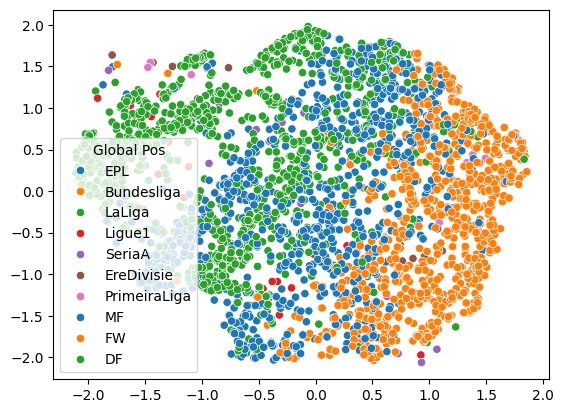

In [21]:
X_team = StandardScaler().fit_transform(df_team_features_scaled)
sns.scatterplot(x=X_team[:,0], y=X_team[:,1],hue=df_team_info_squad["League"])

X_player = StandardScaler().fit_transform(df_player_features_scaled)
sns.scatterplot(x=X_player[:,0], y=X_player[:,1],hue=player_info["Global Pos"]) # 


c:\Users\Alexander Lorenz\anaconda3\envs\ml\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



<Axes: >

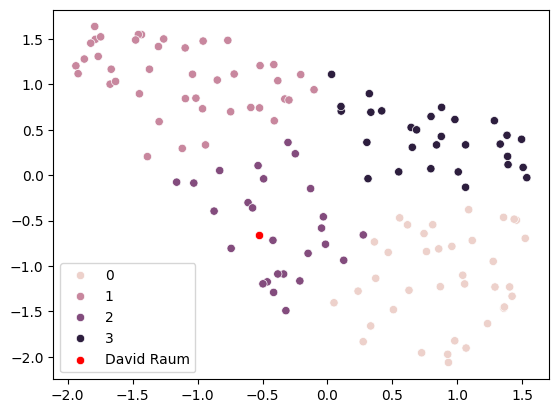

In [22]:
model = KMeans(n_clusters=4).fit(X_team)
teams_labeled = model.predict(X_team)


sns.scatterplot(x=X_team[:,0], y=X_team[:,1],hue=teams_labeled)
sns.scatterplot(x=[X_player[raum_idx,0]], y=[X_player[raum_idx,1]],
                color='red', label="David Raum")

In [23]:
label = model.predict(X_player[raum_idx].reshape(1, -1))

eval = pd.DataFrame({
    "Team": df_team_info_squad["Team"],
    "Label" : teams_labeled
})

eval[eval["Label"] == label[0]].head(40)

,Team,Label
Team,,
Aston Villa,Aston Villa,2
Fulham,Fulham,2
Crystal Palace,Crystal Palace,2
Chelsea,Chelsea,2
Leicester City,Leicester City,2
Real Sociedad,Real Sociedad,2
Betis,Betis,2
Athletic Club,Athletic Club,2
Rayo Vallecano,Rayo Vallecano,2


__Conclusion__:
<br>
Even though we would anticipate obvious clusters, it is actually not

In [24]:

def_cols = ['Tackles_Def 3rd', 'Tackles_Mid 3rd','Tackles_Att 3rd']

possession_cols = ['Touches_Def Pen', 'Touches_Def 3rd',
       'Touches_Mid 3rd', 'Touches_Att 3rd', 'Touches_Att Pen','Take-Ons_Att', 'Carries_TotDist',
       'Carries_PrgDist', 'Carries_PrgC', 'Carries_1/3', 'Carries_CPA','Receiving_Succ', 'Receiving_PrgR'
        ]



### 2nd try

<Axes: xlabel='Tackles_Mid 3rd', ylabel='Tackles_Att 3rd'>

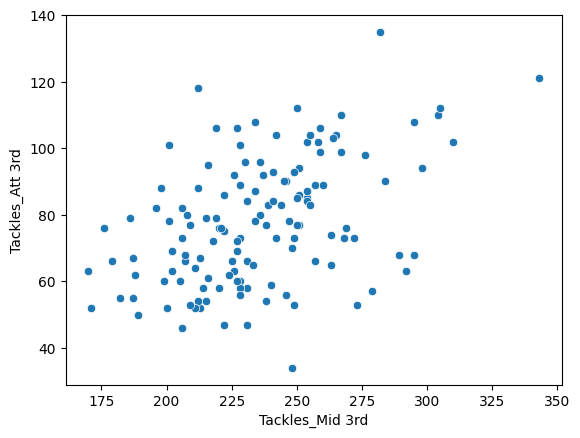

In [25]:
x = df_squad_features["Tackles_Mid 3rd"]
y = df_squad_features["Tackles_Att 3rd"]
sns.scatterplot(data=df_squad_features,x=x, y=y)

In [26]:
from sklearn.preprocessing import QuantileTransformer

QuantileTransformer().fit_transform(eval[def_cols])

KeyError: "None of [Index(['Tackles_Def 3rd', 'Tackles_Mid 3rd', 'Tackles_Att 3rd'], dtype='object')] are in the [columns]"

In [306]:
eval

,Tackles_Def 3rd,Tackles_Mid 3rd,Tackles_Att 3rd,def_quantile,mid_quantile,att_quantile
Team,,,,,,
Manchester City,185.0,198.0,88.0,0.007463,0.089552,0.705224
Arsenal,238.0,212.0,118.0,0.119403,0.238806,0.985075
Manchester Utd,343.0,231.0,84.0,0.828358,0.496269,0.641791
Newcastle Utd,268.0,254.0,85.0,0.376866,0.757463,0.660448
Liverpool,228.0,250.0,112.0,0.059701,0.708955,0.973881
...,...,...,...,...,...,...
Estoril,251.0,209.0,53.0,0.216418,0.205224,0.082090
Portimonense,241.0,225.0,66.0,0.141791,0.380597,0.313433
Marítimo,282.0,234.0,78.0,0.462687,0.529851,0.544776


<Axes: xlabel='def_quantile', ylabel='att_quantile'>

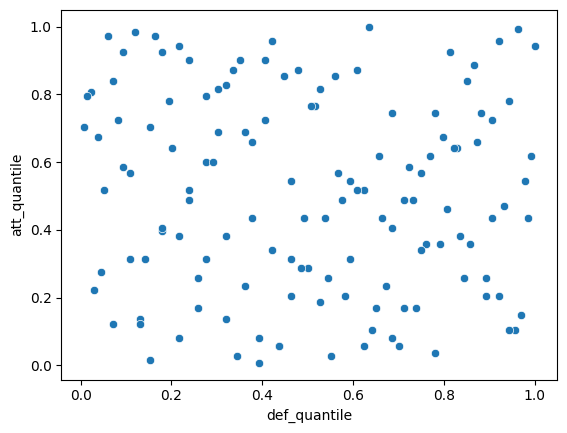

In [307]:
eval = pd.DataFrame({
    "Tackles_Def 3rd":df_squad_features["Tackles_Def 3rd"],
    "Tackles_Mid 3rd":df_squad_features["Tackles_Mid 3rd"],
    "Tackles_Att 3rd":df_squad_features["Tackles_Att 3rd"]
})

eval['def_quantile'] = eval['Tackles_Def 3rd'].rank(pct=True)
eval['mid_quantile'] = eval['Tackles_Mid 3rd'].rank(pct=True)
eval['att_quantile'] = eval['Tackles_Att 3rd'].rank(pct=True)

eval

x = eval['def_quantile']
y = eval['att_quantile']
sns.scatterplot(data=eval,x=x, y=y)

In [308]:
eval['att_quantile'].min()

0.007462686567164179

In [309]:
import pandas as pd
import numpy as np

# Generate the data
np.random.seed(42)
data = {
    'A': df_squad_features["Tackles_Mid 3rd"]
}

# Create DataFrame
df = pd.DataFrame(data)
df

# Calculate the quantile for each value in column 'A'
df['A_quantile'] = df['A'].rank(pct=True)

# Display the first few rows to verify
df[['A', 'A_quantile']].sort_values(by="A_quantile",ascending=False).head()


,A,A_quantile
Team,,
Leeds United,343.0,1.000000
Monaco,310.0,0.992537
Benfica,305.0,0.985075
Marseille,304.0,0.977612
Sporting CP,298.0,0.970149


## Compare to defenders of the team
<br>
Assumption:
Current player match the playing style of a team. If similar player are already in a team than they the qualities of David Raum are played currently

# GPT: Euclidean, Cosine, Mahalanobis Distance
Mahalanobis Distance seems quite promising incombination with pca

In [310]:
import pandas as pd
from sklearn.preprocessing import StandardScaler,Normalizer
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from scipy.spatial.distance import mahalanobis
import numpy as np
from sklearn.decomposition import PCA

# Step 1: Normalize the data

def normalize_data(player_stats, team_stats, n_components=50):
    """
    Normalize player and team stats using Z-score normalization.
    """
    # Step 1: Normalize the data
    scaler = StandardScaler()
    
    # Fit the scaler on team stats to normalize both player and team stats on the same scale
    team_stats_normalized = scaler.fit_transform(team_stats)
    player_stats_normalized = scaler.transform([player_stats])  # We normalize the player stats separately but use the same scaler
    
    # Step 2: Apply PCA for dimensionality reduction
    pca = PCA(n_components=n_components)
    
    # Fit PCA on the team stats (since teams have more data) and transform both player and team stats
    team_stats_reduced = pca.fit_transform(team_stats_normalized)
    player_stats_reduced = pca.transform(player_stats_normalized)[0]  # We need only the transformed player stats array
    
    return player_stats_reduced, team_stats_reduced

# Step 2: Calculate Euclidean Distance and Cosine Similarity

def calculate_distances(player_stats_normalized, team_stats_normalized):
    """
    Calculate Euclidean distance and Cosine similarity between Player A's stats and each team's stats.
    """
    # Euclidean distance between player and teams
    euclidean_dist = euclidean_distances([player_stats_normalized], team_stats_normalized)[0]
    
    # Cosine similarity between player and teams
    cosine_sim = cosine_similarity([player_stats_normalized], team_stats_normalized)[0]

    # Covariance matrix of the team stats
    cov_matrix = np.cov(team_stats_normalized, rowvar=False)
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    
    # Calculate Mahalanobis distance for each team
    maha_distances = [mahalanobis(player_stats_normalized, team, inv_cov_matrix) for team in team_stats_normalized]
    
    return euclidean_dist, cosine_sim, maha_distances

# Step 3: Rank Teams by Similarity

def rank_teams(euclidean_dist, cosine_sim, maha_distances, team_names):
    """
    Rank teams based on Euclidean distance, Cosine similarity, and Mahalanobis distance.
    
    Args:
        euclidean_dist (array): Euclidean distances between player and teams.
        cosine_sim (array): Cosine similarities between player and teams.
        maha_distances (array): Mahalanobis distances between player and teams.
        team_names (list): List of team names corresponding to the stats.
    
    Returns:
        pd.DataFrame: DataFrame containing teams, distances, similarities, and rankings.
    """
    # Create a DataFrame to store the results
    similarity_df = pd.DataFrame({
        'Team': team_names,
        'Euclidean_Distance': euclidean_dist,
        'Cosine_Similarity': cosine_sim,
        'Mahalanobis_Distance': maha_distances
    })
    
    # Rank teams by Euclidean distance (lower is more similar)
    similarity_df['Euclidean_Rank'] = similarity_df['Euclidean_Distance'].rank(method='min')
    
    # Rank teams by Mahalanobis distance (lower is more similar)
    similarity_df['Mahalanobis_Rank'] = similarity_df['Mahalanobis_Distance'].rank(method='min')
    
    # Rank teams by Cosine similarity (higher is better, so reverse the rank)
    similarity_df['Cosine_Rank'] = similarity_df['Cosine_Similarity'].rank(method='min', ascending=False)
    
    # Sort by the Euclidean distance first, but you can change the sorting based on your preference
    similarity_df = similarity_df.sort_values(by=['Euclidean_Distance', 'Cosine_Similarity','Mahalanobis_Distance']).reset_index(drop=True)
    
    return similarity_df


player = df_features.loc['Christopher Nkunku']

player_stats_normalized, team_stats_normalized = normalize_data(player, df_squad_features, n_components=13)

# Calculate distances
euclidean_dist, cosine_sim, mahalanobis = calculate_distances(player_stats_normalized, team_stats_normalized)

# Rank teams
ranked_teams = rank_teams(euclidean_dist, cosine_sim,mahalanobis, df_squad_features.index)

ranked_teams.head(50)

c:\Users\Alexander Lorenz\anaconda3\envs\ml\Lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



,Team,Euclidean_Distance,Cosine_Similarity,Mahalanobis_Distance,Euclidean_Rank,Mahalanobis_Rank,Cosine_Rank
0,Augsburg,37.015849,0.640428,17.416599,1.0,15.0,10.0
1,Union Berlin,37.525753,0.653193,17.413159,2.0,14.0,8.0
2,Hertha BSC,37.534338,0.673995,16.760497,3.0,5.0,7.0
3,Estoril,37.656178,0.701172,17.167400,4.0,12.0,4.0
4,Boavista,37.709085,0.855834,15.849257,5.0,1.0,2.0
5,Vizela,37.731935,0.736640,16.424364,6.0,3.0,3.0
6,Freiburg,38.165347,0.694531,17.514725,7.0,21.0,6.0
7,Santa Clara,38.485762,0.583895,17.494827,8.0,20.0,16.0
8,Hoffenheim,38.901287,0.861488,17.024037,9.0,9.0,1.0
9,Paços,39.009604,0.573334,17.595301,10.0,24.0,19.0


first predict the best cluster for the player using Euclidean distance and then compute the Cosine similarity only for the teams within that predicted cluster.

The scaled, components have the same value range kind of

In [311]:
player_stats_reduced

NameError: name 'player_stats_reduced' is not defined

In [6]:
team_stats_reduced[:,0]

array([ 17.8956769 ,  11.54779714,   5.70155027,   5.48888721,
        11.85935654,  10.06765328,  -0.08902285,   3.51417981,
        -3.96223771,  -0.25482879,  -1.44267548,   5.37459051,
        -2.97765703,  -3.29578063,  -7.4791988 , -10.47685249,
        -6.02440992,  -2.17681776,  -4.31298591,  -5.8849563 ,
        14.89294534,   9.92094548,   6.31518238,  -5.05724956,
        -3.07832135,   1.93190343,   0.63320962,  -1.41354021,
        -5.86083428,  -0.22096508,  -2.92061858,  -4.04070215,
        -4.737393  , -11.15352439, -10.59581093,  -0.58754856,
        -9.43387715,  -9.5479362 ,  16.00117672,  16.09264473,
         5.7332445 ,   2.90114795,   6.76818541,  -0.69807344,
        -2.46462145,   3.85766834,  -7.5624691 ,   1.10841224,
        -0.46232567,   0.26149284,  -0.11298228,  -9.47615275,
        -9.83032573,   0.08119767,  -4.50203495,  -4.37541614,
        -6.00799836,  -6.30071332,  17.11940556,   9.60221557,
         8.17780894,   8.91670141,  10.78910018,   4.01